In [51]:
%load_ext sql
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '16'

figdir = '/home/glandrum/Papers/MolecularTimeSeries/images/'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Get assays with an associated document and pchembl_values from the local ChEMBL30 install

In [2]:
connection_string = f"postgresql://ccg_read@scotland/chembl_32"

%sql $connection_string \
     drop table if exists Ki_targets


%sql \
select tid,targets.chembl_id target_chembl_id,count(distinct(molregno)) cnt,pref_name,assay_organism,bao_format  \
into temporary table Ki_targets \
          from activities join assays using(assay_id) \
          join target_dictionary as targets using (tid)\
          join docs on (activities.doc_id = docs.doc_id) \
          where standard_type = 'Ki' \
          and confidence_score=9 and assay_type='B' and relationship_type='D' \
          and pchembl_value is not null and standard_units = 'nM' \
          and data_validity_comment is null \
          and lower(assays.description) not like '%mutant%' \
          and lower(assays.description) not like '%recombinant%'  \
          and assays.assay_strain is null and assays.assay_category is null \
          group by (tid,targets.chembl_id,pref_name,assays.assay_organism,assays.bao_format) order by cnt desc



Done.
 * postgresql://ccg_read@scotland/chembl_32
2783 rows affected.


[]

In [3]:
%sql \
     drop table if exists Kd_targets


%sql \
select tid,targets.chembl_id target_chembl_id,count(distinct(molregno)) cnt,pref_name  \
into temporary table Kd_targets \
          from activities join assays using(assay_id) \
          join target_dictionary as targets using (tid)\
          join docs on (activities.doc_id = docs.doc_id) \
          where standard_type = 'Kd' \
          and confidence_score=9 and assay_type='B' and relationship_type='D' \
          and pchembl_value is not null and standard_units = 'nM' \
          and data_validity_comment is null \
          and lower(assays.description) not like '%mutant%' \
          and lower(assays.description) not like '%recombinant%'  \
          and assays.assay_strain is null and assays.assay_category is null \
          group by (tid,targets.chembl_id,pref_name,assays.assay_organism,assays.assay_category,assays.bao_format) order by cnt desc



 * postgresql://ccg_read@scotland/chembl_32
Done.
 * postgresql://ccg_read@scotland/chembl_32
2006 rows affected.


[]

Look at count histograms

 * postgresql://ccg_read@scotland/chembl_32
2783 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
2006 rows affected.


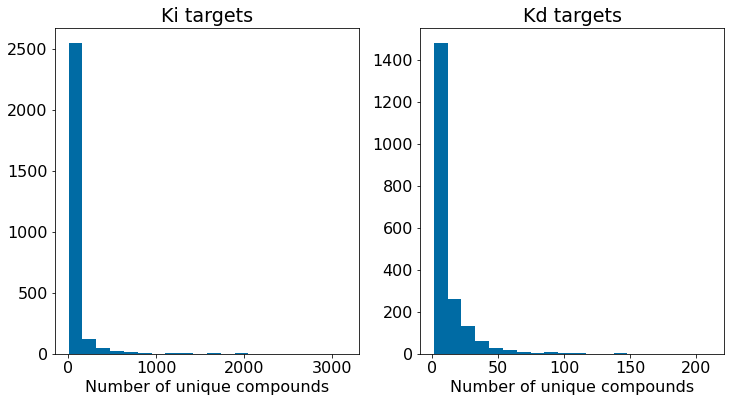

In [4]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
d = %sql select * from Ki_targets order by cnt desc;
df = d.DataFrame()
plt.hist(df.cnt,bins=20)
plt.xlabel('Number of unique compounds');
plt.title("Ki targets")

plt.subplot(1,2,2)
d = %sql select * from Kd_targets order by cnt desc;
df_Kd = d.DataFrame()
plt.hist(df_Kd.cnt,bins=20)
plt.xlabel('Number of unique compounds');
plt.title("Kd targets");

Kd targets will not be interesting here.

 * postgresql://ccg_read@scotland/chembl_32
99 rows affected.


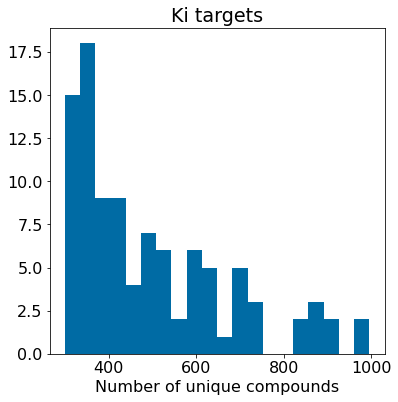

In [37]:
plt.figure(figsize=(6,6))
d = %sql select * from Ki_targets where cnt>=300 and cnt<=1000 order by cnt desc;
df = d.DataFrame()
plt.hist(df.cnt,bins=20)
plt.xlabel('Number of unique compounds');
plt.title("Ki targets");


In [6]:
len(df)

99

In [7]:
df.target_chembl_id

0         CHEMBL217
1         CHEMBL219
2         CHEMBL259
3        CHEMBL4792
4         CHEMBL253
          ...      
94        CHEMBL269
95       CHEMBL1821
96       CHEMBL3227
97       CHEMBL3155
98    CHEMBL1293269
Name: target_chembl_id, Length: 99, dtype: object

In [38]:
tids = df.tid.to_list()
tchemblids = df.target_chembl_id.to_list()
aorgs = df.assay_organism.to_list()
afmts = df.bao_format.to_list()

In [39]:
len(tids),len(set(tids))

(99, 78)

In [40]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.MolStandardize import rdMolStandardize
import pickle
import gzip
import ga_lib_3 as ga_lib
from rdkit import rdBase
rdBase.DisableLog('rdApp.info')

from collections import Counter
cntr = Counter()
for tid,tchemblid,aorg,afmt in zip(df.tid,df.target_chembl_id,df.assay_organism,df.bao_format):
    print(tchemblid)
    d = %sql \
    select molregno,canonical_smiles,cidl.chembl_id compound_chembl_id,pchembl_value  \
              from activities join assays using (assay_id) \
              join compound_structures using (molregno) \
              join chembl_id_lookup cidl on (entity_id=molregno and entity_type='COMPOUND')\
              where tid = :tid  \
              and assay_organism=:aorg and assay_category is null and bao_format=:afmt \
              and standard_type = 'Ki' \
              and confidence_score=9 and assay_type='B' and relationship_type='D' \
              and pchembl_value is not null and standard_units = 'nM' \
              and data_validity_comment is null \
              and lower(assays.description) not like '%mutant%' \
              and lower(assays.description) not like '%recombinant%'  \
              and assays.assay_strain is null and assays.assay_category is null                
    dataset = []
    seen = set()
    for mrn,smi,cid,sv in d:
        if cid in seen:
            continue
        seen.add(cid)
        m = Chem.MolFromSmiles(smi)
        if not m:
            continue
        m = rdMolStandardize.ChargeParent(m)
        dataset.append((mrn,smi,cid,sv,m))
    cntr[tchemblid] += 1
    with gzip.open(f'./results/{tchemblid}-{cntr[tchemblid]}_Ki.pkl.gz','wb+') as outf:
        pickle.dump(dataset,outf)
    

    


CHEMBL217
 * postgresql://ccg_read@scotland/chembl_32
1223 rows affected.
CHEMBL219
 * postgresql://ccg_read@scotland/chembl_32
1119 rows affected.
CHEMBL259
 * postgresql://ccg_read@scotland/chembl_32
1055 rows affected.
CHEMBL4792
 * postgresql://ccg_read@scotland/chembl_32
920 rows affected.
CHEMBL253
 * postgresql://ccg_read@scotland/chembl_32
1095 rows affected.
CHEMBL255
 * postgresql://ccg_read@scotland/chembl_32
943 rows affected.
CHEMBL228
 * postgresql://ccg_read@scotland/chembl_32
994 rows affected.
CHEMBL214
 * postgresql://ccg_read@scotland/chembl_32
968 rows affected.
CHEMBL224
 * postgresql://ccg_read@scotland/chembl_32
991 rows affected.
CHEMBL2014
 * postgresql://ccg_read@scotland/chembl_32
785 rows affected.
CHEMBL3759
 * postgresql://ccg_read@scotland/chembl_32
928 rows affected.
CHEMBL264
 * postgresql://ccg_read@scotland/chembl_32
784 rows affected.
CHEMBL344
 * postgresql://ccg_read@scotland/chembl_32
842 rows affected.
CHEMBL4860
 * postgresql://ccg_read@scotland

In [43]:
for fn in glob.glob('./results/*_Ki.pkl.gz'):
    tgt = fn.split('/')[-1].split('.pkl.gz')[0]
    print(tgt)
    with gzip.open(fn,'rb') as inf:
        data = pickle.load(inf)
    print(len(data))

CHEMBL228-1_Ki
858
CHEMBL214-1_Ki
837
CHEMBL224-1_Ki
830
CHEMBL2014-1_Ki
749
CHEMBL3759-1_Ki
732
CHEMBL264-1_Ki
723
CHEMBL344-1_Ki
687
CHEMBL4860-1_Ki
694
CHEMBL245-1_Ki
690
CHEMBL5071-1_Ki
690
CHEMBL4794-1_Ki
686
CHEMBL5113-1_Ki
678
CHEMBL5113-2_Ki
642
CHEMBL234-1_Ki
640
CHEMBL1908389-1_Ki
630
CHEMBL3769-1_Ki
627
CHEMBL4005-1_Ki
619
CHEMBL240-1_Ki
606
CHEMBL238-1_Ki
592
CHEMBL2820-1_Ki
585
CHEMBL4908-1_Ki
583
CHEMBL222-1_Ki
580
CHEMBL240-2_Ki
579
CHEMBL3952-1_Ki
577
CHEMBL228-2_Ki
576
CHEMBL218-1_Ki
543
CHEMBL302-1_Ki
539
CHEMBL225-1_Ki
524
CHEMBL273-1_Ki
523
CHEMBL1800-1_Ki
518
CHEMBL3952-2_Ki
514
CHEMBL1945-1_Ki
507
CHEMBL1946-1_Ki
505
CHEMBL3837-1_Ki
498
CHEMBL211-1_Ki
485
CHEMBL318-1_Ki
482
CHEMBL216-1_Ki
480
CHEMBL3371-1_Ki
476
CHEMBL1862-1_Ki
463
CHEMBL2366517-1_Ki
448
CHEMBL2056-1_Ki
443
CHEMBL1075104-1_Ki
442
CHEMBL4616-1_Ki
434
CHEMBL1889-1_Ki
431
CHEMBL313-1_Ki
429
CHEMBL225-2_Ki
423
CHEMBL270-1_Ki
422
CHEMBL270-2_Ki
413
CHEMBL313-2_Ki
411
CHEMBL4153-1_Ki
409
CHEMBL287-1_Ki


In [41]:
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import pickle
import gzip
import ga_lib_3 as ga_lib
import glob
import numpy as np

cluster_accum = {}
generator = rdFingerprintGenerator.GetMorganGenerator(radius=2)
for fn in glob.glob('./results/*_Ki.pkl.gz'):
    tgt = fn.split('/')[-1].split('.pkl.gz')[0]
    print(tgt)
    with gzip.open(fn,'rb') as inf:
        data = pickle.load(inf)

    fps = ga_lib.get_fps(x[-1] for x in data)

    # generate the distance matrix based on the fingerprints:
    dmat = np.zeros((len(fps), len(fps)), float)
    for i, fp in enumerate(fps):
        if i == len(fps) - 1:
            break
        ds = np.array(
            DataStructs.BulkTanimotoSimilarity(fp,
                                               fps[i + 1:],
                                               returnDistance=1))
        dmat[i, i + 1:] = ds
        dmat[i + 1:, i] = ds
    distThreshold = 0.65
    clusterSizeThreshold = max(5, len(dmat) / 50)
    clusters = ga_lib.clusterData(dmat,
                           distThreshold,
                           clusterSizeThreshold=clusterSizeThreshold)
    cluster_accum[tgt] = clusters    

CHEMBL228-1_Ki
CHEMBL214-1_Ki
CHEMBL224-1_Ki
CHEMBL2014-1_Ki
CHEMBL3759-1_Ki
CHEMBL264-1_Ki
CHEMBL344-1_Ki
CHEMBL4860-1_Ki
CHEMBL245-1_Ki
CHEMBL5071-1_Ki
CHEMBL4794-1_Ki
CHEMBL5113-1_Ki
CHEMBL5113-2_Ki
CHEMBL234-1_Ki
CHEMBL1908389-1_Ki
CHEMBL3769-1_Ki
CHEMBL4005-1_Ki
CHEMBL240-1_Ki
CHEMBL238-1_Ki
CHEMBL2820-1_Ki
CHEMBL4908-1_Ki
CHEMBL222-1_Ki
CHEMBL240-2_Ki
CHEMBL3952-1_Ki
CHEMBL228-2_Ki
CHEMBL218-1_Ki
CHEMBL302-1_Ki
CHEMBL225-1_Ki
CHEMBL273-1_Ki
CHEMBL1800-1_Ki
CHEMBL3952-2_Ki
CHEMBL1945-1_Ki
CHEMBL1946-1_Ki
CHEMBL3837-1_Ki
CHEMBL211-1_Ki
CHEMBL318-1_Ki
CHEMBL216-1_Ki
CHEMBL3371-1_Ki
CHEMBL1862-1_Ki
CHEMBL2366517-1_Ki
CHEMBL2056-1_Ki
CHEMBL1075104-1_Ki
CHEMBL4616-1_Ki
CHEMBL1889-1_Ki
CHEMBL313-1_Ki
CHEMBL225-2_Ki
CHEMBL270-1_Ki
CHEMBL270-2_Ki
CHEMBL313-2_Ki
CHEMBL4153-1_Ki
CHEMBL287-1_Ki
CHEMBL233-1_Ki
CHEMBL2326-1_Ki
CHEMBL236-1_Ki
CHEMBL3510-1_Ki
CHEMBL5112-1_Ki
CHEMBL344-2_Ki
CHEMBL273-2_Ki
CHEMBL237-1_Ki
CHEMBL2954-1_Ki
CHEMBL3729-1_Ki
CHEMBL222-2_Ki
CHEMBL219-2_Ki
CHEMBL251-1_Ki


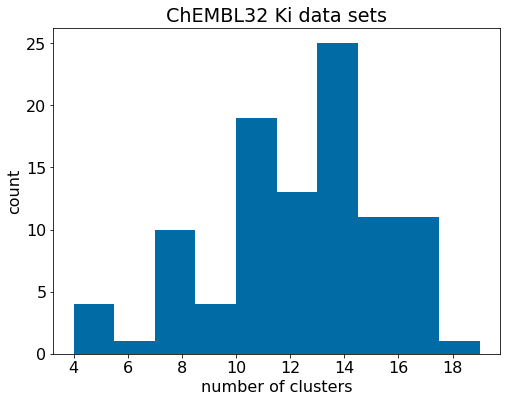

In [42]:
plt.figure(figsize=(8,6))
plt.hist([len(x) for x in cluster_accum.values()]);
plt.xlabel('number of clusters')
plt.ylabel('count')
plt.title('ChEMBL32 Ki data sets');

These actually look pretty good.

Generate the intake data catalog file 

In [44]:
import numpy as np
yaml=[]


cntr = Counter()
for tid,tchemblid,aorg,afmt in zip(tids,tchemblids,aorgs,afmts):
    d = %sql \
    select distinct on (cidl.chembl_id) canonical_smiles,cidl.chembl_id compound_chembl_id,pchembl_value  \
              from activities join assays using (assay_id) \
              join compound_structures using (molregno) \
              join chembl_id_lookup cidl on (entity_id=molregno and entity_type='COMPOUND')\
              where tid = :tid and standard_type = 'Ki' \
              and assay_organism=:aorg and assay_category is null and bao_format=:afmt \
              and confidence_score=9 and assay_type='B' and relationship_type='D' \
              and pchembl_value is not null and standard_units = 'nM' \
              and data_validity_comment is null \
              and lower(assays.description) not like '%mutant%' \
              and lower(assays.description) not like '%recombinant%'              
    cntr[tid] += 1;
    dataset = []
    df = d.DataFrame()
    df.to_csv(f'./datasets/source_data/target_{tchemblid}-{cntr[tid]}.csv.gz',index=False)
    
    minAct = min(df.pchembl_value)
    maxAct = max(df.pchembl_value)
    medAct = np.median(df.pchembl_value)
    actType = 'Ki'
    targetd = %sql \
    select * from target_dictionary  \
        where tid=:tid
    targetd = dict(targetd[0])
    template=f'''  {tchemblid}-{cntr[tid]}:
    description: "Target {tchemblid}: {targetd['pref_name']}"
    args:
      filename: '{{{{ CATALOG_DIR }}}}/source_data/target_{tchemblid}-{cntr[tid]}.csv.gz'
      smilesColumn: canonical_smiles
    metadata:
      url: https://www.ebi.ac.uk/chembl/target_report_card/{tchemblid}/
      source: ChEMBL_32
      organism: {targetd['organism']}
      assay_organism: {aorg}
      assay_bao_format: {afmt}
      activity_type: {actType}
      min pchembl_value: {minAct:.2f}
      max pchembl_value: {maxAct:.2f}
      median pchembl_value: {medAct:.2f}
    driver: intake_rdkit.smiles.SmilesSource
'''
    yaml.append(template)
print('\n'.join(yaml))
with open('./datasets/targets.yaml','w+') as outf:
    header='''metadata:
  version: 1
  creator: 
    name: greg landrum
    email: glandrum@ethz.ch

  summary: |
    Collection of Ki datasets with pchembl_values for bioactivity prediction.

    Each row includes the reported value. Only values without data_validity_comments are included
    
sources:'''
    print(header,file=outf)
    print('\n'.join(yaml),file=outf)
    

 * postgresql://ccg_read@scotland/chembl_32
996 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
969 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
925 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
907 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
881 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
861 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
858 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
837 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.
 * postg

365 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
364 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
360 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
360 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
358 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
358 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
357 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
355 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
1 rows affected.
 * postgresql://ccg_read@scotland/chembl_32
354 rows

# Baseline ML models

In [45]:
import numpy as np
from collections import namedtuple
restuple = namedtuple('restuple',['rocs','scores','kappas','BAs'])

import pickle
import glob
import os
import gzip
tmp_assays = glob.glob('./mfp0_nogap_ml_results_balanced/*.pkl.gz')
mfp0_nogap_random_results_bal = {}
for fn in tmp_assays:
    assay = os.path.basename(fn).split('_')[0]
    with gzip.open(fn,'rb') as inf:
        tpl = restuple(*pickle.load(inf))
    mfp0_nogap_random_results_bal[assay] = tpl

tmp_assays = glob.glob('./nogap_ml_results_balanced/*.pkl.gz')
nogap_random_results_bal = {}
for fn in tmp_assays:
    assay = os.path.basename(fn).split('_')[0]
    with gzip.open(fn,'rb') as inf:
        tpl = restuple(*pickle.load(inf))
    nogap_random_results_bal[assay] = tpl
    
# tmp_assays = glob.glob('./mfp0_nogap_ml_results_imbalanced/*.pkl.gz')
# mfp0_nogap_random_results_imbal = {}
# for fn in tmp_assays:
#     assay = os.path.basename(fn).split('_')[0]
#     with gzip.open(fn,'rb') as inf:
#         tpl = restuple(*pickle.load(inf))
#     mfp0_nogap_random_results_imbal[assay] = tpl

# tmp_assays = glob.glob('./nogap_ml_results_imbalanced/*.pkl.gz')
# nogap_random_results_imbal = {}
# for fn in tmp_assays:
#     assay = os.path.basename(fn).split('_')[0]
#     with gzip.open(fn,'rb') as inf:
#         tpl = restuple(*pickle.load(inf))
#     nogap_random_results_imbal[assay] = tpl
    

Text(0.5, 1.0, 'balanced')

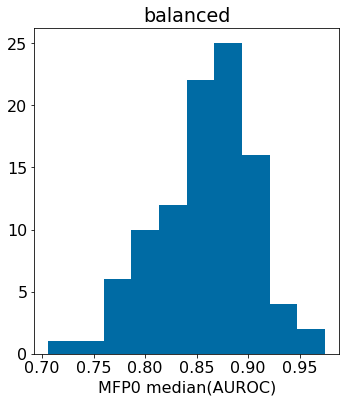

In [46]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
meds = np.array([np.median(mfp0_nogap_random_results_bal[x].rocs) for x in  mfp0_nogap_random_results_bal])
plt.hist(meds);
plt.xlabel('MFP0 median(AUROC)')
plt.title('balanced')

# plt.subplot(1,2,2)
# meds = np.array([np.median(mfp0_nogap_random_results_imbal[x].rocs) for x in  mfp0_nogap_random_results_imbal])
# plt.hist(meds);
# plt.xlabel('MFP0 median(AUROC)')
# plt.title('imbalanced');


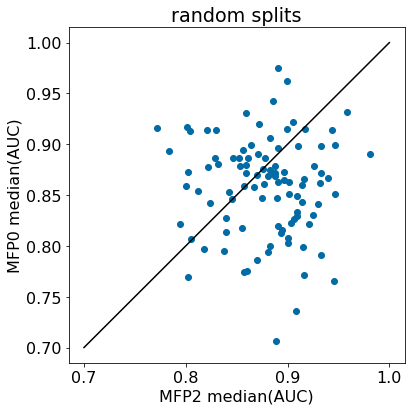

In [60]:
plt.figure(figsize=(6,6))

bal_meds = np.array([np.median(nogap_random_results_bal[x].rocs) for x in  nogap_random_results_bal])
mfp0_bal_meds = np.array([np.median(mfp0_nogap_random_results_bal[x].rocs) for x in  mfp0_nogap_random_results_bal])

plt.scatter(bal_meds,mfp0_bal_meds)
plt.plot((0.7,1),(0.7,1),'k-');
plt.xlabel('MFP2 median(AUC)')
plt.ylabel('MFP0 median(AUC)')
plt.title('random splits');

plt.tight_layout()
plt.savefig(f'{figdir}/chembl_assays_mfp0_vs_mfp2.pdf',bbox_inches='tight')


In [48]:
targets[assay].metadata

{'url': 'https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL5113/',
 'source': 'ChEMBL_32',
 'organism': 'Homo sapiens',
 'assay_organism': 'Homo sapiens',
 'assay_bao_format': 'BAO_0000219',
 'activity_type': 'Ki',
 'min pchembl_value': 4.36,
 'max pchembl_value': 9.7,
 'median pchembl_value': 6.92,
 'catalog_dir': '/localhome/glandrum/Projects/SIMPD_sets2/./datasets/'}

In [49]:
import intake
targets = intake.open_catalog('./datasets/targets.yaml')

order = sorted([(x.split('-')[0],x) for x in targets])
tgts = [y for x,y in order]

sizes = []
for target in tgts:
    ds = targets[target]
    sizes.append(len(ds.read()))
    tgt = target.split('-')[0]
    print(rf"{target} & {tgt} & {ds.metadata['assay_organism']} & {ds.metadata['assay_bao_format']} & {sizes[-1]}")
#     print(rf'{assay} & {ds.metadata["activity_type"]} & {sizes[-1]} \\')
# len(sizes)

CHEMBL1075104-1 & CHEMBL1075104 & Homo sapiens & BAO_0000357 & 442
CHEMBL1293269-1 & CHEMBL1293269 & Hepatitis C virus & BAO_0000357 & 300
CHEMBL1800-1 & CHEMBL1800 & Homo sapiens & BAO_0000219 & 518
CHEMBL1821-1 & CHEMBL1821 & Homo sapiens & BAO_0000219 & 308
CHEMBL1833-1 & CHEMBL1833 & Homo sapiens & BAO_0000357 & 338
CHEMBL1833-2 & CHEMBL1833 & Homo sapiens & BAO_0000219 & 318
CHEMBL1862-1 & CHEMBL1862 & Homo sapiens & BAO_0000357 & 463
CHEMBL1871-1 & CHEMBL1871 & Homo sapiens & BAO_0000219 & 347
CHEMBL1889-1 & CHEMBL1889 & Homo sapiens & BAO_0000219 & 431
CHEMBL1908389-1 & CHEMBL1908389 & Homo sapiens & BAO_0000357 & 630
CHEMBL1945-1 & CHEMBL1945 & Homo sapiens & BAO_0000219 & 507
CHEMBL1946-1 & CHEMBL1946 & Homo sapiens & BAO_0000219 & 505
CHEMBL2014-1 & CHEMBL2014 & Homo sapiens & BAO_0000219 & 749
CHEMBL2035-1 & CHEMBL2035 & Homo sapiens & BAO_0000219 & 346
CHEMBL2056-1 & CHEMBL2056 & Homo sapiens & BAO_0000219 & 443
CHEMBL210-1 & CHEMBL210 & Homo sapiens & BAO_0000219 & 333
CHE

In [56]:
import intake
targets = intake.open_catalog('./datasets/targets.yaml')

order = sorted([(x.split('-')[0],x) for x in targets])
tgts = [y for x,y in order]

sizes = []
print("dataset, target, assay organism, assay BAO format, size")
for target in tgts:
    ds = targets[target]
    sizes.append(len(ds.read()))
    tgt = target.split('-')[0]
    print(rf"{target}, {tgt}, {ds.metadata['assay_organism']}, {ds.metadata['assay_bao_format']}, {sizes[-1]}")
#     print(rf'{assay} & {ds.metadata["activity_type"]} & {sizes[-1]} \\')
# len(sizes)

dataset, target, assay organism, assay BAO format, size
CHEMBL1075104-1, CHEMBL1075104, Homo sapiens, BAO_0000357, 442
CHEMBL1293269-1, CHEMBL1293269, Hepatitis C virus, BAO_0000357, 300
CHEMBL1800-1, CHEMBL1800, Homo sapiens, BAO_0000219, 518
CHEMBL1821-1, CHEMBL1821, Homo sapiens, BAO_0000219, 308
CHEMBL1833-1, CHEMBL1833, Homo sapiens, BAO_0000357, 338
CHEMBL1833-2, CHEMBL1833, Homo sapiens, BAO_0000219, 318
CHEMBL1862-1, CHEMBL1862, Homo sapiens, BAO_0000357, 463
CHEMBL1871-1, CHEMBL1871, Homo sapiens, BAO_0000219, 347
CHEMBL1889-1, CHEMBL1889, Homo sapiens, BAO_0000219, 431
CHEMBL1908389-1, CHEMBL1908389, Homo sapiens, BAO_0000357, 630
CHEMBL1945-1, CHEMBL1945, Homo sapiens, BAO_0000219, 507
CHEMBL1946-1, CHEMBL1946, Homo sapiens, BAO_0000219, 505
CHEMBL2014-1, CHEMBL2014, Homo sapiens, BAO_0000219, 749
CHEMBL2035-1, CHEMBL2035, Homo sapiens, BAO_0000219, 346
CHEMBL2056-1, CHEMBL2056, Homo sapiens, BAO_0000219, 443
CHEMBL210-1, CHEMBL210, Homo sapiens, BAO_0000219, 333
CHEMBL211-1

In [53]:
print(figdir)

/home/glandrum/Papers/MolecularTimeSeries/images/


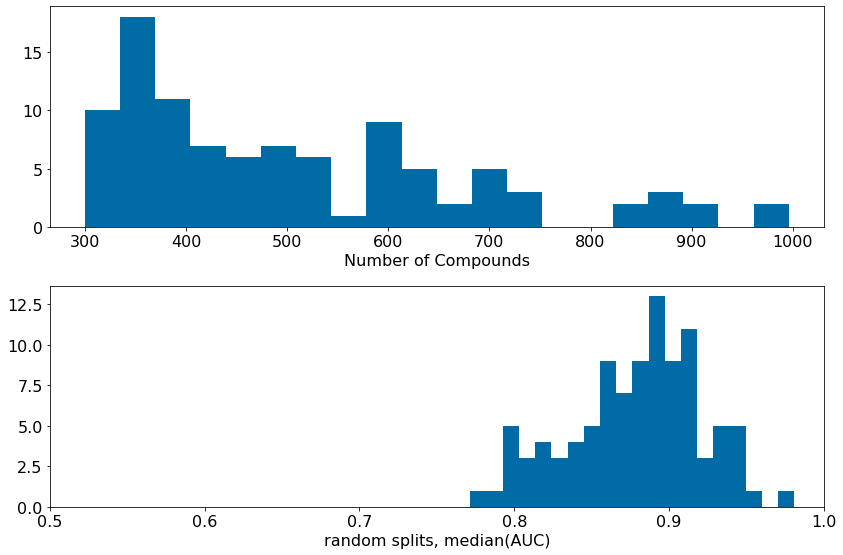

In [58]:

plt.figure(figsize=(12,8))


plt.subplot(2,1,1)
plt.hist(sizes,
     bins=20, 
     );
plt.xlabel('Number of Compounds')
plt.subplot(2,1,2)
plt.hist([
     [np.median(nogap_random_results_bal[x].rocs) for x in tgts],
],
     bins=20, 
     );
plt.xlim(0.5,1.0);
plt.xlabel('random splits, median(AUC)');
plt.tight_layout()
plt.savefig(f'{figdir}/chembl_assays_summary.pdf',bbox_inches='tight')
